Attempting to load data files...
✅ Files loaded successfully!
Original images shape: (1260, 1024, 1024, 4)

Resizing and normalizing 1260 images and masks...
✅ Processing complete.

Freed memory by deleting original large arrays.
Shape of processed images: (1260, 256, 256, 4)
Shape of processed masks: (1260, 256, 256)
Unique mask values (should be 0. and 1.): [0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313726
 0.04705882 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667
 0.07058824 0.07450981 0.07843138 0.08235294 0.08627451 0.09019608
 0.09411765 0.09803922 0.10196079 0.10588235 0.10980392 0.11372549
 0.11764706 0.12156863 0.1254902  0.12941177 0.13333334 0.13725491
 0.14117648 0.14509805 0.14901961 0.15294118 0.15686275 0.16078432
 0.16470589 0.16862746 0.17254902 0.1764706  0.18039216 0.18431373
 0.1882353  0.19215687 0.19607843 0.2        0.20392157 0.20784314
 0.21176471 0.21568628 0.21960784 0

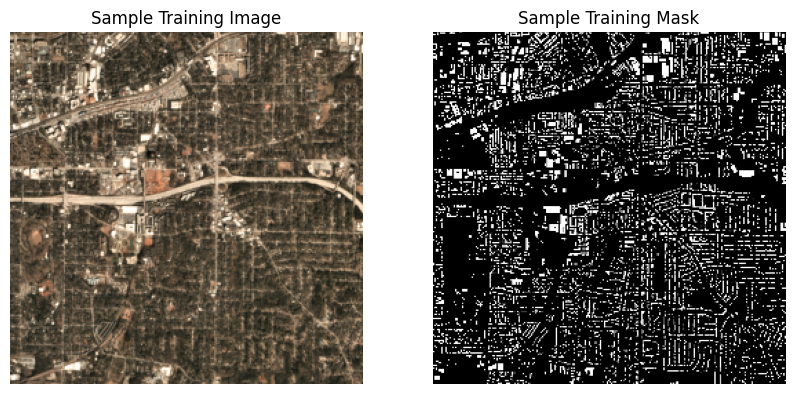

In [3]:
# --- Step 1: Import Necessary Libraries ---
import numpy as np
import joblib as jlb
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gc # Garbage collector, to free up memory

# --- Step 2: Load Data From Your Local Folder ---
try:
    print("Attempting to load data files...")
    ims = jlb.load('ims.np')
    mas = jlb.load('mas.np')
    print("✅ Files loaded successfully!")
    print(f"Original images shape: {ims.shape}")
except Exception as e:
    print(f"❌ Error loading files: {e}")
    raise

# --- Step 3 & 4: (Combined) Resize and Normalize Efficiently ---
# We process one image at a time to avoid MemoryError.
IMG_SIZE = 256
resized_images = []
resized_masks = []

print(f"\nResizing and normalizing {len(ims)} images and masks...")

for i in range(len(ims)):
    # --- Process Image ---
    # 1. Resize the large image
    img_resized = cv2.resize(ims[i], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
    # 2. Normalize the smaller, resized image
    img_normalized = img_resized.astype('float32') / 255.0
    resized_images.append(img_normalized)
    
    # --- Process Mask ---
    # 1. Resize the large mask
    mask_resized = cv2.resize(mas[i], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    # 2. Normalize the smaller, resized mask (This fixes the model training error!)
    mask_normalized = (mask_resized / 255.0).astype('float32')
    resized_masks.append(mask_normalized)

print("✅ Processing complete.")

# --- Free up memory ---
# We delete the huge original arrays to save RAM
del ims
del mas
gc.collect() # Ask the garbage collector to clear the memory
print("\nFreed memory by deleting original large arrays.")

# --- Convert lists to final NumPy arrays ---
images_processed = np.array(resized_images)
masks_processed = np.array(resized_masks)

print(f"Shape of processed images: {images_processed.shape}")
print(f"Shape of processed masks: {masks_processed.shape}")
print(f"Unique mask values (should be 0. and 1.): {np.unique(masks_processed)}")

# Add a "channel" dimension to the masks array for model compatibility
if masks_processed.ndim == 3:
    masks_processed = np.expand_dims(masks_processed, axis=-1)

# --- Step 5: Split Data into Training and Validation Sets ---
print("\nSplitting data into training and validation sets...")
X_train, X_val, y_train, y_val = train_test_split(
    images_processed, masks_processed, test_size=0.2, random_state=42
)
print("✅ Data splitting complete.")
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

# --- (Optional) Step 6: Visualize a Sample to Verify ---
print("\nDisplaying one sample image and its mask...")
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_train[0]) # Display the normalized image
plt.title("Sample Training Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(y_train[0], cmap='gray') # Display the normalized mask
plt.title("Sample Training Mask")
plt.axis('off')
plt.show()


Displaying a grid of random training samples for exploration...


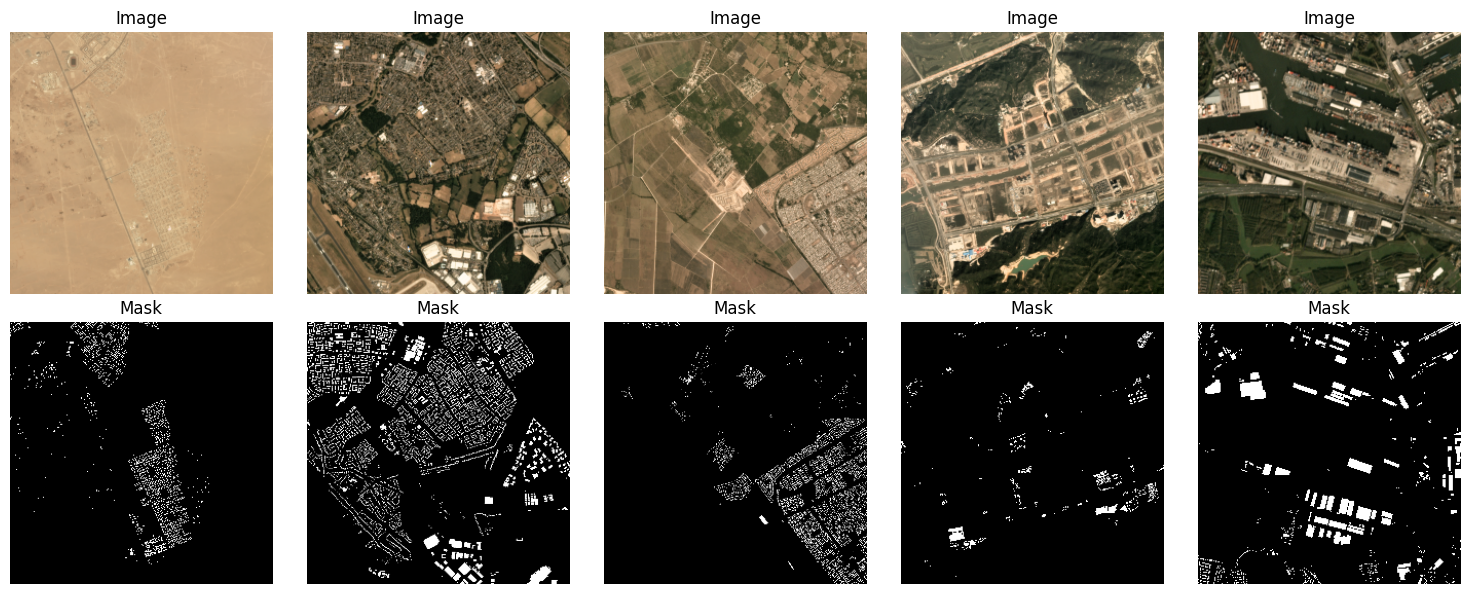

In [9]:
# --- Code for Exploration: Displaying a Grid of Samples ---

print("\nDisplaying a grid of random training samples for exploration...")

# Choose 5 random images from the training set
num_samples = 5
random_indices = np.random.choice(X_train.shape[0], num_samples, replace=False)

plt.figure(figsize=(15, 6)) # Adjust figure size for better layout

for i, index in enumerate(random_indices):
    # Display Image
    ax = plt.subplot(2, num_samples, i + 1)
    ax.imshow(X_train[index])
    ax.set_title("Image")
    ax.axis('off')

    # Display Mask
    ax = plt.subplot(2, num_samples, i + 1 + num_samples)
    ax.imshow(y_train[index], cmap='gray')
    ax.set_title("Mask")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
import matplotlib.pyplot as plt
import numpy as np
import pickle

# --- Define the U-Net Model ---

def build_unet(input_shape):
    inputs = Input(input_shape)

    # --- Encoder (Down-sampling path) ---
    # Block 1
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # Block 2
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Block 3
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # --- Bottleneck ---
    c_mid = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c_mid = Dropout(0.2)(c_mid)
    c_mid = Conv2D(128, (3, 3), activation='relu', padding='same')(c_mid)

    # --- Decoder (Up-sampling path) ---
    # Block 6
    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c_mid)
    u6 = concatenate([u6, c3]) # Skip connection
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

    # Block 7
    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c2]) # Skip connection
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

    # Block 8
    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c1]) # Skip connection
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same')(c8)

    # --- Final Output Layer ---
    # We use a 1x1 convolution with a 'sigmoid' activation.
    # Sigmoid is perfect for binary tasks (pixel is either 'building' or 'not building').
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c8)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [11]:
# --- Step 3: Build & Compile the Model ---
# We'll use the 4-channel input shape
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 4 # Your images are 4-channel

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

# Build the model
model = build_unet(input_shape)

# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2, name='mean_iou')])

# Print a summary of the model architecture
model.summary()

# --- Step 4: Train the Model ---
# This will use the X_train, y_train variables you just created
EPOCHS = 25
BATCH_SIZE = 16

print("\n--- Starting Model Training ---")

# Train the model
history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val))

print("\n--- Model Training Complete ---")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        592 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │     32,832 │ conv2d_7[0][0]  

 Total params: 482,177 (1.84 MB)

 Trainable params: 482,177 (1.84 MB)

 Non-trainable params: 0 (0.00 B)


--- Starting Model Training ---
Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.9248 - loss: 0.2817 - mean_iou: 0.4703 - val_accuracy: 0.9216 - val_loss: 0.2429 - val_mean_iou: 0.4684
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.9260 - loss: 0.2346 - mean_iou: 0.4703 - val_accuracy: 0.9216 - val_loss: 0.2406 - val_mean_iou: 0.4684
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9260 - loss: 0.2314 - mean_iou: 0.4703 - val_accuracy: 0.9216 - val_loss: 0.2366 - val_mean_iou: 0.4684
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.9260 - loss: 0.2292 - mean_iou: 0.4703 - val_accuracy: 0.9216 - val_loss: 0.2339 - val_mean_iou: 0.4684
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9260 - loss: 0.2246 - mean_iou: 0.4703 - val_accuracy: 0.9216 - val_loss: 0.2303 - val_mean_iou: 0.4684
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.9260 - loss: 0.2190 - mean_iou: 0.4703 - val_accuracy: 0.

In [12]:
import pickle

# --- Save the Model ---
model_filename = 'unet_satellite_model.h5'
model.save(model_filename)
print(f"✅ Model saved as {model_filename}")

# --- Save the Training History (Results) ---
# 'history' is the variable created by model.fit()
history_filename = 'training_history.pkl'
with open(history_filename, 'wb') as f:
    pickle.dump(history.history, f)
print(f"✅ Training history saved as {history_filename}")

✅ Model saved as unet_satellite_model.h5
✅ Training history saved as training_history.pkl


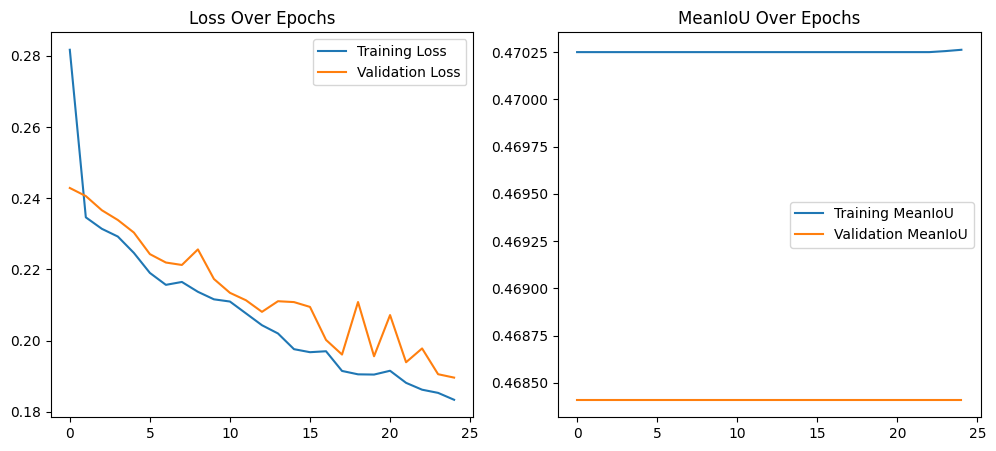


--- Displaying Model Predictions on Validation Data ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


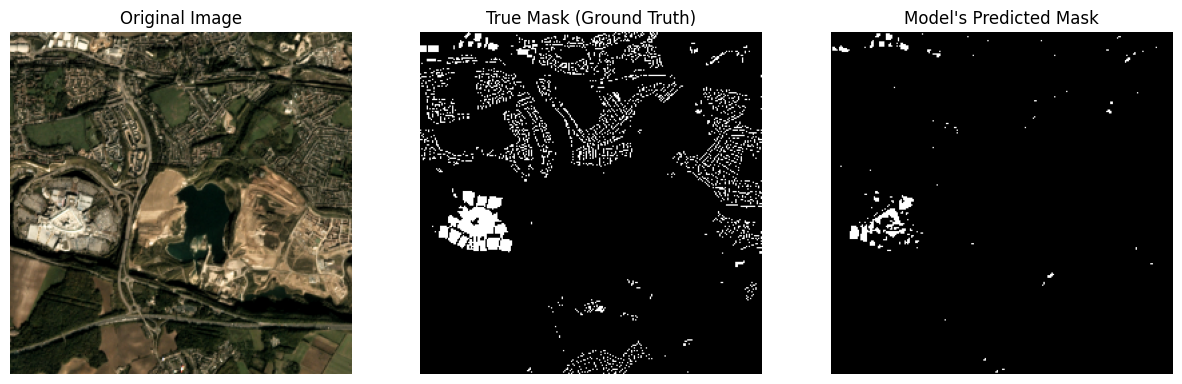

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


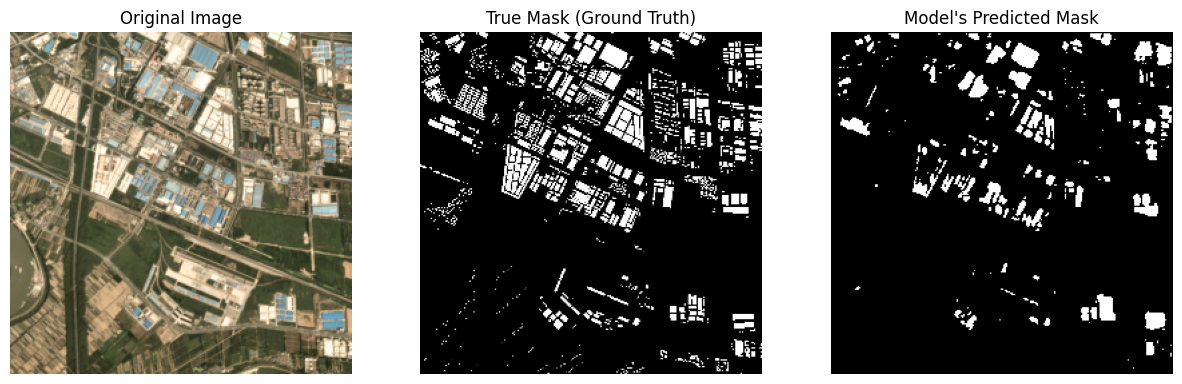

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


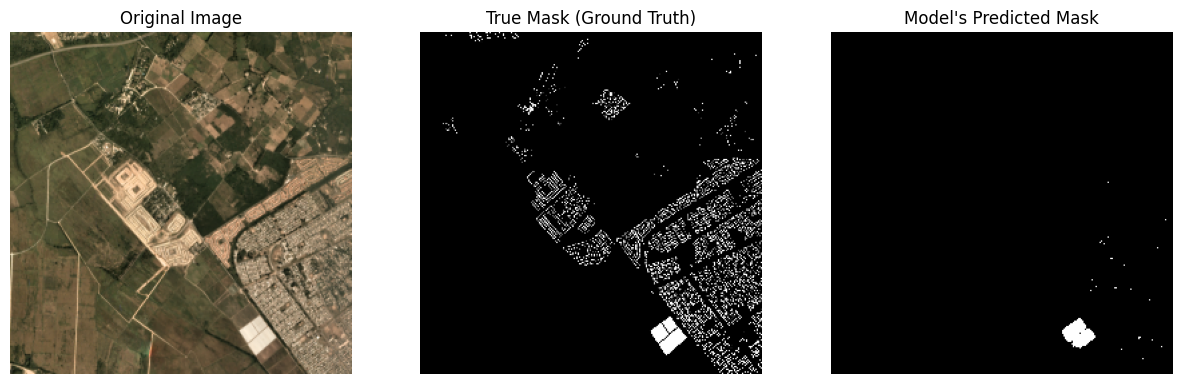

In [13]:
# --- 1. Plot Training History ---
history_data = history.history

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_data['loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_data['mean_iou'], label='Training MeanIoU')
plt.plot(history_data['val_mean_iou'], label='Validation MeanIoU')
plt.title('MeanIoU Over Epochs')
plt.legend()
plt.show()

# --- 2. Visualize Predictions ---
print("\n--- Displaying Model Predictions on Validation Data ---")

# Pick 3 random images from the validation set
for _ in range(3):
    idx = np.random.randint(0, len(X_val))

    # Get the image, its true mask, and the model's prediction
    test_image = X_val[idx]
    true_mask = y_val[idx]
    
    # Model needs a "batch" dimension, so we add it
    test_image_input = np.expand_dims(test_image, axis=0) 
    
    # Make the prediction
    predicted_mask_raw = model.predict(test_image_input)[0]
    
    # Convert the prediction (probabilities from 0-1) into a binary mask (0 or 1)
    predicted_mask = (predicted_mask_raw > 0.5).astype(np.uint8) 

    # Plot the results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(test_image)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title('True Mask (Ground Truth)')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Model\'s Predicted Mask')
    plt.axis('off')
    
    plt.show()

In [6]:
import tensorflow.keras.backend as K

# --- Define Custom Loss Functions for Imbalanced Data ---

def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Calculates the Dice coefficient (a.k.a. F1 score) for binary segmentation.
    """
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    """
    Calculates the Dice loss.
    This is 1 - Dice coefficient.
    """
    return 1 - dice_coefficient(y_true, y_pred)

def dice_bce_loss(y_true, y_pred):
    """
    A combined loss function that uses both Binary Cross-Entropy and Dice Loss
    to get the best of both worlds.
    """
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

In [7]:
# --- Step 7: Import TensorFlow/Keras Libraries ---
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, 
    concatenate, Conv2DTranspose, BatchNormalization, Dropout
)
from tensorflow.keras.optimizers import Adam  # <-- ADD THIS LINE
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import MeanIoU

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.20.0


In [8]:
# --- Step 9: Compile the Model ---
print("\nCompiling the model...")
model.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss='binary_crossentropy', 
    metrics=['accuracy', MeanIoU(num_classes=2, name='mean_iou')]
)


Compiling the model...


NameError: name 'model' is not defined

In [13]:
# --- Step 9: Compile the Model (Using New Loss Function) ---
print("\nCompiling the model with Dice+BCE Loss...")
model.compile(
    optimizer=Adam(learning_rate=1e-4), # You might try 1e-3 if 1e-4 is too slow
    loss=dice_bce_loss,                 # <-- HERE is the change
    metrics=['accuracy', MeanIoU(num_classes=2, name='mean_iou'), dice_coefficient] # Track dice_coeff
)
print("✅ Model compiled.")


Compiling the model with Dice+BCE Loss...
✅ Model compiled.


In [14]:
print(f"Unique mask values (should be 0. and 1.): {np.unique(masks_processed)}")

Unique mask values (should be 0. and 1.): [0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313726
 0.04705882 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667
 0.07058824 0.07450981 0.07843138 0.08235294 0.08627451 0.09019608
 0.09411765 0.09803922 0.10196079 0.10588235 0.10980392 0.11372549
 0.11764706 0.12156863 0.1254902  0.12941177 0.13333334 0.13725491
 0.14117648 0.14509805 0.14901961 0.15294118 0.15686275 0.16078432
 0.16470589 0.16862746 0.17254902 0.1764706  0.18039216 0.18431373
 0.1882353  0.19215687 0.19607843 0.2        0.20392157 0.20784314
 0.21176471 0.21568628 0.21960784 0.22352941 0.22745098 0.23137255
 0.23529412 0.23921569 0.24313726 0.24705882 0.2509804  0.25490198
 0.25882354 0.2627451  0.26666668 0.27058825 0.27450982 0.2784314
 0.28235295 0.28627452 0.2901961  0.29411766 0.29803923 0.3019608
 0.30588236 0.30980393 0.3137255  0.31764707 0.32156864 0.3254902
 0.32941177 0.33333334 

In [15]:
# --- Add Channel Dimension ---
# The model expects (Batch, Height, Width, Channels), so (H, W) becomes (H, W, 1)
if masks_processed.ndim == 3:
    masks_processed = np.expand_dims(masks_processed, axis=-1)
    print(f"\nAdded channel dimension. New masks shape: {masks_processed.shape}")

# --- Split Data into Training and Validation Sets ---
print("\nSplitting data into training and validation sets...")
X_train, X_val, y_train, y_val = train_test_split(
    images_processed, masks_processed, test_size=0.2, random_state=42
)
print("✅ Data splitting complete.")
print(f"Training images shape: {X_train.shape}")
print(f"Training masks shape: {y_train.shape}")
print(f"Validation images shape: {X_val.shape}")
print(f"Validation masks shape: {y_val.shape}")


Splitting data into training and validation sets...
✅ Data splitting complete.
Training images shape: (1008, 256, 256, 4)
Training masks shape: (1008, 256, 256, 1)
Validation images shape: (252, 256, 256, 4)
Validation masks shape: (252, 256, 256, 1)


In [17]:
# ... (your model.fit code is above this) ...

print("\n--- Model Training Complete ---")

# --- ADD THIS LINE AT THE BOTTOM ---
model.save('unet_satellite_model.h5')
print("✅ Model saved successfully as unet_satellite_model.h5")


--- Model Training Complete ---
✅ Model saved successfully as unet_satellite_model.h5


In [1]:
# --- Step 1: Download and Unzip the Dataset ---
# This is a server-to-server transfer and is very fast.
!kaggle datasets download -d sabermalek/spacenetsi --unzip

print("✅ Dataset downloaded and unzipped!")

# --- Step 2: Import Joblib ---
# This fixes the "jlb is not defined" error.
import joblib as jlb

# --- Step 3: Load the Files ---
# This will now work because the files are in your Colab session.
print("Loading data files...")
ims = jlb.load('ims.np')
mas = jlb.load('mas.np')

print("✅ Files loaded successfully!")
print(f"Images shape: {ims.shape}")
print(f"Masks shape: {mas.shape}")

'kaggle' is not recognized as an internal or external command,
operable program or batch file.


✅ Dataset downloaded and unzipped!
Loading data files...
✅ Files loaded successfully!
Images shape: (1260, 1024, 1024, 4)
Masks shape: (1260, 1024, 1024)


In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Define a name for your new folder ---
output_folder = "saved_images"

# --- 2. Create the folder (if it doesn't exist) ---
os.makedirs(output_folder, exist_ok=True)
print(f"✅ Folder '{output_folder}' created.")

# --- 3. Loop and save 5 images ---
num_images_to_save = 5

print(f"Saving {num_images_to_save} images...")
for i in range(num_images_to_save):
    # Get an image from your training set (shape 256, 256, 4)
    img = X_train[i]
    
    # We only save the first 3 channels (RGB) to make it a standard .jpg
    # plt.imsave works directly with your normalized (0.0 to 1.0) images
    rgb_img = img[:, :, :3]
    
    # Define the new filename
    filename = os.path.join(output_folder, f"image_{i}.jpg")
    
    # Save the image
    plt.imsave(filename, rgb_img)

print(f"✅ Successfully saved {num_images_to_save} images to the '{output_folder}' folder.")


✅ Folder 'saved_images' created.
Saving 5 images...
✅ Successfully saved 5 images to the 'saved_images' folder.


In [18]:
# This will save the model in the new .keras format
model.save('unet_satellite_model.keras')